In [1]:
import pandas as pd
import numpy as np
import os

In [17]:
pip install pytorch_tabnet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [7]:
data_path = "/Users/minyoungxi/DataScience/kaggle/감귤 착과량/open/"

train_raw_df = pd.read_csv(data_path + "train.csv")
test_raw_df = pd.read_csv(data_path + "test.csv")

In [65]:
train_raw_df

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,2022-09-01 새순,2022-09-02 새순,2022-09-03 새순,2022-09-04 새순,2022-09-05 새순,2022-09-06 새순,2022-09-07 새순,2022-09-08 새순,2022-09-09 새순,2022-09-10 새순,2022-09-11 새순,2022-09-12 새순,2022-09-13 새순,2022-09-14 새순,2022-09-15 새순,2022-09-16 새순,2022-09-17 새순,2022-09-18 새순,2022-09-19 새순,2022-09-20 새순,2022-09-21 새순,2022-09-22 새순,2022-09-23 새순,2022-09-24 새순,2022-09-25 새순,2022-09-26 새순,2022-09-27 새순,2022-09-28 새순,2022-09-29 새순,2022-09-30 새순,2022-10-01 새순,2022-10-02 새순,2022-10-03 새순,2022-10-04 새순,2022-10-05 새순,2022-10-06 새순,2022-10-07 새순,2022-10-08 새순,2022-10-09 새순,2022-10-10 새순,2022-10-11 새순,2022-10-12 새순,2022-10-13 새순,2022-10-14 새순,2022-10-15 새순,2022-10-16 새순,2022-10-17 새순,2022-10-18 새순,2022-10-19 새순,2022-10-20 새순,2022-10-21 새순,2022-10-22 새순,2022-10-23 새순,2022-10-24 새순,2022-10-25 새순,2022-10-26 새순,2022-10-27 새순,2022-10-28 새순,2022-10-29 새순,2022-10-30 새순,2022-10-31 새순,2022-11-01 새순,2022-11-02 새순,2022-11-03 새순,2022-11-04 새순,2022-11-05 새순,2022-11-06 새순,2022-11-07 새순,2022-11-08 새순,2022-11-09 새순,2022-11-10 새순,2022-11-11 새순,2022-11-12 새순,2022-11-13 새순,2022-11-14 새순,2022-11-15 새순,2022-11-16 새순,2022-11-17 새순,2022-11-18 새순,2022-11-19 새순,2022-11-20 새순,2022-11-21 새순,2022-11-22 새순,2022-11-23 새순,2022-11-24 새순,2022-11-25 새순,2022-11-26 새순,2022-11-27 새순,2022-11-28 새순,2022-09-01 엽록소,2022-09-02 엽록소,2022-09-03 엽록소,2022-09-04 엽록소,2022-09-05 엽록소,2022-09-06 엽록소,2022-09-07 엽록소,2022-09-08 엽록소,2022-09-09 엽록소,2022-09-10 엽록소,2022-09-11 엽록소,2022-09-12 엽록소,2022-09-13 엽록소,2022-09-14 엽록소,2022-09-15 엽록소,2022-09-16 엽록소,2022-09-17 엽록소,2022-09-18 엽록소,2022-09-19 엽록소,2022-09-20 엽록소,2022-09-21 엽록소,2022-09-22 엽록소,2022-09-23 엽록소,2022-09-24 엽록소,2022-09-25 엽록소,2022-09-26 엽록소,2022-09-27 엽록소,2022-09-28 엽록소,2022-09-29 엽록소,2022-09-30 엽록소,2022-10-01 엽록소,2022-10-02 엽록소,2022-10-03 엽록소,2022-10-04 엽록소,2022-10-05 엽록소,2022-10-06 엽록소,2022-10-07 엽록소,2022-10-08 엽록소,2022-10-09 엽록소,2022-10-10 엽록소,2022-10-11 엽록소,2022-10-12 엽록소,2022-10-13 엽록소,2022-10-14 엽록소,2022-10-15 엽록소,2022-10-16 엽록소,2022-10-17 엽록소,2022-10-18 엽록소,2022-10-19 엽록소,2022-10-20 엽록소,2022-10-21 엽록소,2022-10-22 엽록소,2022-10-23 엽록소,2022-10-24 엽록소,2022-10-25 엽록소,2022-10-26 엽록소,2022-10-27 엽록소,2022-10-28 엽록소,2022-10-29 엽록소,2022-10-30 엽록소,2022-10-31 엽록소,2022-11-01 엽록소,2022-11-02 엽록소,2022-11-03 엽록소,2022-11-04 엽록소,2022-11-05 엽록소,2022-11-06 엽록소,2022-11-07 엽록소,2022-11-08 엽록소,2022-11-09 엽록소,2022-11-10 엽록소,2022-11-11 엽록소,2022-11-12 엽록소,2022-11-13 엽록소,2022-11-14 엽록소,2022-11-15 엽록소,2022-11-16 엽록소,2022-11-17 엽록소,2022-11-18 엽록소,2022-11-19 엽록소,2022-11-20 엽록소,2022-11-21 엽록소,2022-11-22 엽록소,2022-11-23 엽록소,2022-11-24 엽록소,2022-11-25 엽록소,2022-11-26 엽록소,2022-11-27 엽록소,2022-11-28 엽록소
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2.8,2.8,2.7,2.7,2.7,2.7,2.6,2.6,2.6,2.6,2.5,2.5,2.5,2.5,2.4,2.4,2.4,2.4,2.3,2.3,2.3,2.3,2.2,2.2,2.2,2.2,2.1,2.1,2.1,2.1,2.0,2.0,2.0,2.0,1.9,1.9,1.9,1.9,1.8,1.8,1.8,1.8,1.7,1.7,1.7,1.7,1.6,1.6,1.6,1.6,1.5,1.5,1.5,1.5,1.4,1.4,1.4,1.4,1.3,1.3,1.3,1.2,1.2,1.2,1.2,1.2,1.1,1.1,1.1,1.1,1.0,1.0,1.0,1.0,1.0,0.9,0.9,0.9,0.9,0.9,0.8,0.8,0.8,0.7,0.7,0.7,0.7,0.7,0.6,78.336504,78.243462,78.166501,78.127526,78.058021,77.915689,77.861660,77.746645,77.592138,77.572477,77.382045,77.211789,77.151051,77.063069,76.905981,76.868475,76.732897,76.669280,76.662585,76.519409,76.349661,76.186091,76.040207,75.999415,75.990592,75.953731,75.829564,75.798673,75.621243,75.427005,75.266187,75.226094,75.162319,75.079444,75.013855,74.935697,74.842749,74.836657,74.816928,74.788574,74.690358,74.504942,74.394908,74.351704,74.166346,74.020254,73.835142,73.766164,73.755269,73.627395,73.465457,73.395076,73.311405,73.243028,73.087409,73.081651,73.023755,72.987263,72.977606,72.838462,72.645386,72.512869,72.445908,72.370097,72.301180,72.228374,72.207746,72.068354,71.987663,71.869466,71.852923,71.690854,71.576402,71.384018,71.301893,71.234817,71.076903,70.996113,70.985843,70.978249,70.876794,70.705253,70.559603,70.427356,70.340491,70.293830,70.262422,70.169841,70.043251
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,3.3,3.3,3.3,3.2,3.2,3.1,3.1,3.1,3.0,3.0,3.0,2.

In [32]:
y_var = ['착과량(int)']
id_var = list(train_raw_df.columns[2:6])
seasoon = list(train_raw_df.columns[6:95])
yuprokso = list(train_raw_df.columns[95:])

In [41]:
# 시계열 데이터 처리를 위한 멜팅 작업 

train_melt = train_raw_df.melt(id_vars=['ID']+y_var+id_var, value_vars=seasoon+yuprokso)
train_melt
# pandas melt -> id_vars를 기준으로 value_vars를 행으로 녹이는 것.

test_melt = test_raw_df.melt(id_vars=['ID']+id_var, value_vars=seasoon+yuprokso)

train_melt['date'] = train_melt['variable'].apply(lambda x: x.split(' ')[0]) # 날짜만 분리 
train_melt['type'] = train_melt['variable'].apply(lambda x: x.split(' ')[1]) # 종류만 분리 

test_melt['date'] = test_melt['variable'].apply(lambda x: x.split(' ')[0])
test_melt['type'] = test_melt['variable'].apply(lambda x: x.split(' ')[1])

#### pandas drop_duplicated() 

* boolean type 으로 반환
* 중복되는 값이 있으면 True , 삭제

#### reset_index(drop=True)

* index 를 초기화하고 기존 인덱스 제거

In [44]:
train_melt_preproc = train_melt[['ID']+y_var+id_var+['date']].drop_duplicates().reset_index(drop=True).merge(
train_melt[train_melt['type']=='새순'][['ID', 'date', 'value']].rename(columns={'value':'새순'}), how='left')

train_melt_preproc

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,date,새순
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2022-09-01,2.8
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,2022-09-01,3.3
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,2022-09-01,3.0
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,2022-09-01,3.1
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,2022-09-01,3.7
...,...,...,...,...,...,...,...,...
196418,TRAIN_2202,119,230.0,353.0,367.0,360.0,2022-11-28,0.0
196419,TRAIN_2203,611,266.0,337.0,400.0,368.5,2022-11-28,0.6
196420,TRAIN_2204,650,237.0,353.0,362.0,357.5,2022-11-28,0.5
196421,TRAIN_2205,363,281.0,337.0,403.0,370.0,2022-11-28,0.0


In [46]:
train_melt_preproc = train_melt[['ID']+y_var+id_var+['date']].drop_duplicates().reset_index(drop=True).merge(
    train_melt[train_melt['type']=='새순'][['ID', 'date', 'value']].rename(columns={'value':'새순'}),
    how='left'
).merge(
    train_melt[(train_melt['type']=='새순')&(train_melt['date']=='2022-09-01')][['ID', 'value']].rename(columns={'value':'새순0'}),
    how='left'
).merge(
    train_melt[(train_melt['type']=='새순')&(train_melt['date']=='2022-10-15')][['ID', 'value']].rename(columns={'value':'새순1'}),
    how='left'
).merge(
    train_melt[train_melt['type']=='엽록소'][['ID', 'date', 'value']].rename(columns={'value':'엽록소'}),
    how='left'
)

In [55]:
train_melt_preproc['새순diff0'] = train_melt_preproc['새순']-train_melt_preproc['새순0']
train_melt_preproc['새순diff1'] = train_melt_preproc['새순']-train_melt_preproc['새순1']
train_melt_preproc['엽록소_새순'] = train_melt_preproc['엽록소']/(train_melt_preproc['새순']+0.1)  # 분모 0 방지

In [56]:
train_melt_preproc

,ID,착과량(int),수고(m),수관폭1(min),수관폭2(max),수관폭평균,date,새순,새순0,새순1,엽록소,새순diff0,새순diff1,엽록소_새순
0,TRAIN_0000,692,275.0,287.0,292.0,289.5,2022-09-01,2.8,2.8,1.7,78.336504,0.0,1.1,27.012587
1,TRAIN_0001,534,293.0,284.0,336.0,310.0,2022-09-01,3.3,3.3,1.9,80.116691,0.0,1.4,23.563733
2,TRAIN_0002,634,300.0,392.0,450.0,421.0,2022-09-01,3.0,3.0,1.8,79.118529,0.0,1.2,25.522106
3,TRAIN_0003,639,289.0,368.0,379.0,373.5,2022-09-01,3.1,3.1,1.9,77.936262,0.0,1.2,24.355082
4,TRAIN_0004,496,306.0,353.0,358.0,355.5,2022-09-01,3.7,3.7,2.1,76.233231,0.0,1.6,20.061377
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196418,TRAIN_2202,119,230.0,353.0,367.0,360.0,2022-11-28,0.0,4.7,2.5,65.560547,-4.7,-2.5,655.605473
196419,TRAIN_2203,611,266.0,337.0,400.0,368.5,2022-11-28,0.6,3.1,1.9,72.944396,-2.5,-1.3,104.206281
196420,TRAIN_2204,650,237.0,353.0,362.0,357.5,2022-11-28,0.5,3.0,1.8,66.479459,-2.5,-1.3,110.799099
196421,TRAIN_2205,363,281.0,337.0,403.0,370.0,2022-11-28,0.0,3.9,2.2,65.812084,-3.9,-2.2,658.120840


In [62]:
test_melt_preproc = test_melt[['ID']+id_var+['date']].drop_duplicates().reset_index(drop=True).merge(
    test_melt[test_melt['type']=='새순'][['ID', 'date', 'value']].rename(columns={'value':'새순'}),
    how='left'
).merge(
    test_melt[(test_melt['type']=='새순')&(test_melt['date']=='2022-09-01')][['ID', 'value']].rename(columns={'value':'새순0'}),
    how='left'
).merge(
    test_melt[(test_melt['type']=='새순')&(test_melt['date']=='2022-10-15')][['ID', 'value']].rename(columns={'value':'새순1'}),
    how='left'
).merge(
    test_melt[test_melt['type']=='엽록소'][['ID', 'date', 'value']].rename(columns={'value':'엽록소'}),
    how='left'
)
test_melt_preproc['새순diff0'] = test_melt_preproc['새순']-test_melt_preproc['새순0']
test_melt_preproc['새순diff1'] = test_melt_preproc['새순']-test_melt_preproc['새순1']
test_melt_preproc['엽록소_새순'] = test_melt_preproc['엽록소']/(test_melt_preproc['새순']+0.1) # 분모 0 방지
test_melt_preproc


,ID,수고(m),수관폭1(min),수관폭2(max),수관폭평균,date,새순,새순0,새순1,엽록소,새순diff0,새순diff1,엽록소_새순
0,TEST_0000,231.0,219.0,302.0,260.5,2022-09-01,4.3,4.3,2.3,80.299924,0.0,2.0,18.249983
1,TEST_0001,206.0,324.0,346.0,335.0,2022-09-01,2.5,2.5,1.6,75.389791,0.0,0.9,28.996074
2,TEST_0002,282.0,373.0,404.0,388.5,2022-09-01,4.7,4.7,2.6,82.042248,0.0,2.1,17.092135
3,TEST_0003,234.0,337.0,357.0,347.0,2022-09-01,3.6,3.6,2.1,81.213424,0.0,1.5,21.949574
4,TEST_0004,222.0,329.0,347.0,338.0,2022-09-01,2.7,2.7,1.7,80.665529,0.0,1.0,28.809118
...,...,...,...,...,...,...,...,...,...,...,...,...,...
196507,TEST_2203,217.0,265.0,288.0,276.5,2022-11-28,0.6,2.5,1.5,69.601365,-1.9,-0.9,99.430521
196508,TEST_2204,182.0,191.0,262.0,226.5,2022-11-28,0.0,4.1,2.3,65.632342,-4.1,-2.3,656.323420
196509,TEST_2205,254.0,280.0,332.0,306.0,2022-11-28,0.6,3.8,2.2,62.307955,-3.2,-1.6,89.011365
196510,TEST_2206,257.0,285.0,297.0,291.0,2022-11-28,0.0,4.5,2.5,63.343589,-4.5,-2.5,633.435889


#### pivot 

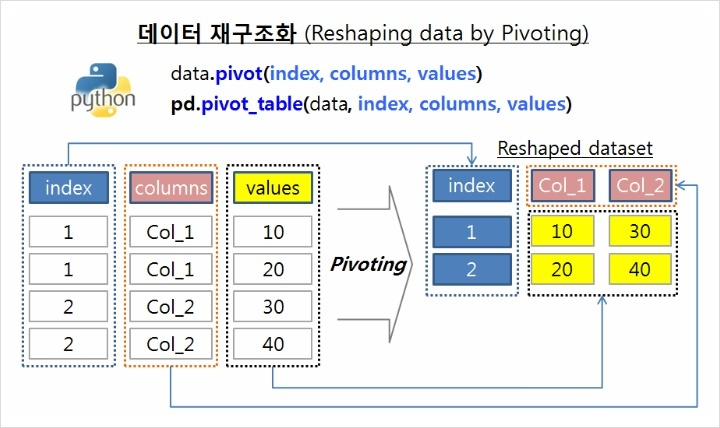

In [63]:
train_df = train_melt_preproc.pivot(index=['ID']+y_var+id_var, columns=['date'],
                                    values=['새순diff0','새순diff1','새순', '엽록소_새순']).reset_index()
test_df = test_melt_preproc.pivot(index=['ID']+id_var, columns=['date'], 
                                  values=['새순diff0','새순diff1', '새순', '엽록소_새순']).reset_index()

In [64]:
train_df

ID 착과량(int)  수고(m) 수관폭1(min) 수관폭2(max)  수관폭평균    새순diff0  \
date                                                        2022-09-01   
0     TRAIN_0000      692  275.0     287.0     292.0  289.5        0.0   
1     TRAIN_0001      534  293.0     284.0     336.0  310.0        0.0   
2     TRAIN_0002      634  300.0     392.0     450.0  421.0        0.0   
3     TRAIN_0003      639  289.0     368.0     379.0  373.5        0.0   
4     TRAIN_0004      496  306.0     353.0     358.0  355.5        0.0   
...          ...      ...    ...       ...       ...    ...        ...   
2202  TRAIN_2202      119  230.0     353.0     367.0  360.0        0.0   
2203  TRAIN_2203      611  266.0     337.0     400.0  368.5        0.0   
2204  TRAIN_2204      650  237.0     353.0     362.0  357.5        0.0   
2205  TRAIN_2205      363  281.0     337.0     403.0  370.0        0.0   
2206  TRAIN_2206       17  228.0     389.0     398.0  393.5        0.0   

                                                                        \
date 2022-09-02 2022-09-03 2022-09-04 2022-09-05 2022-09-06 2022-09-07   
0           0.0       -0.1       -0.1       -0.1       -0.1       -0.2   
1           0.0        0.0       -0.1       -0.1       -0.2       -0.2   
2          -0.1       -0.1       -0.1       -0.1       -0.2       -0.2   
3          -0.1       -0.1       -0.1       -0.1       -0.2       -0.2   
4          -0.1       -0.1       -0.1       -0.2       -0.2       -0.2   
...         ...        ...        ...        ...        ...        ...   
2202       -0.1       -0.2       -0.2       -0.3       -0.3       -0.4   
2203       -0.1       -0.1       -0.1       -0.2       -0.2       -0.2   
2204        0.0       -0.1       -0.1       -0.1       -0.1       -0.2   
2205        0.0       -0.1       -0.1       -0.1       -0.2       -0.2   
2206       -0.1       -0.1       -0.2       -0.3       -0.3       -0.4   

                                                                        \
date 2022-09-08 2022-09-09 2022-09-10 2022-09-11 2022-09-12 2022-09-13   
0          -0.2       -0.2       -0.2       -0.3       -0.3       -0.3   
1          -0.2       -0.3       -0.3       -0.3       -0.4       -0.4   
2          -0.2       -0.2       -0.3       -0.3       -0.3       -0.4   
3          -0.2       -0.3       -0.3       -0.3       -0.4       -0.4   
4          -0.3       -0.3       -0.4       -0.4       -0.4       -0.5   
...         ...        ...        ...        ...        ...        ...   
2202       -0.4       -0.5       -0.5       -0.6       -0.6       -0.7   
2203       -0.2       -0.3       -0.3       -0.3       -0.3       -0.4   
2204       -0.2       -0.2       -0.2       -0.3       -0.3       -0.3   
2205       -0.3       -0.3       -0.3       -0.4       -0.4       -0.5   
2206       -0.4       -0.5       -0.5       -0.6       -0.7       -0.7   

                                                                        \
date 2022-09-14 2022-09-15 2022-09-16 2022-09-17 2022-09-18 2022-09-19   
0          -0.3       -0.4       -0.4       -0.4       -0.4       -0.5   
1          -0.4       -0.4       -0.5       -0.5       -0.5       -0.6   
2          -0.4       -0.4       -0.4       -0.5       -0.5       -0.5   
3          -0.4       -0.4       -0.5       -0.5       -0.5       -0.6   
4          -0.5       -0.5       -0.6       -0.6       -0.6       -0.7   
...         ...        ...        ...        ...        ...        ...   
2202       -0.7       -0.8       -0.8       -0.9       -0.9       -0.9   
2203       -0.4       -0.4       -0.5       -0.5       -0.5       -0.6   
2204       -0.4       -0.4       -0.4       -0.4       -0.5       -0.5   
2205       -0.5       -0.5       -0.6       -0.6       -0.6       -0.7   
2206       -0.8       -0.8       -0.9       -0.9       -1.0       -1.0   

                                                                        \
date 2022-09-20 2022-09-21 2022-09-22 2022-09-23 2022-09-24 2022-09-25   
0          -0.

In [67]:
vars = []

for x in train_df.columns:
    if x[1] == "":
        vars.append(x[0])
    else:
        vars.append(x[0]+''+x[1])
        
train_df.columns=vars
test_df.columns = ['ID']+vars[2:]

In [73]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor

train_x, valid_x, train_y, valid_y = train_test_split(train_df.iloc[:,2:] , train_df[y_var], test_size=0.4, random_state=1740)

In [74]:
# Training
regr = RandomForestRegressor(max_depth=5, random_state=1740, n_estimators=200)
regr.fit(pd.concat([train_x, valid_x], axis=0).iloc[:,4:], pd.concat([train_y, valid_y], axis=0).to_numpy().reshape(-1))


"""결과 저장"""
# Inference
pd.DataFrame({
    'ID':test_df['ID'],
    '착과량(int)':np.array(np.round(regr.predict(test_df.iloc[:,5:]), 0), dtype='int')
}).to_csv('submit_reproduce.csv', index=False, encoding='utf-8-sig')